# Scan analysis

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [122]:
import pandas as pd

import seaborn as sns

import numpy as np
# import matplotlib
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from xgboost import XGBRegressor
import shap


from plots2.fns import (
    get_corner_annotations,
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
)

from poly2.utils import get_dispersal_kernel, trait_vec, beta_dist, gamma_dist
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote

In [3]:
df = pd.read_csv('../outputs/combined/scan_all.csv')

In [4]:
df.head(2)

,run,year,best_dose,n_pos_diff,in_0p0_0p1,in_0p1_0p2,in_0p2_0p3,in_0p3_0p4,in_0p4_0p5,in_0p5_0p6,...,in_0p8_0p9,in_0p9_1p0,mu,b,asymptote,dec_rate_multiplier,m_prop_multiplier,m_scale_multiplier,ME_var,ME_mean
0,0,1,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
1,0,2,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241


## Plot

### Type 1

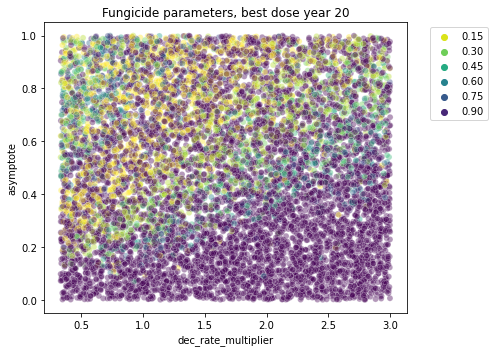

In [5]:
f, ax = plt.subplots(figsize=(7, 5))

dfu = df.loc[lambda x: x.year.isin([20])]

sns.scatterplot(
    x='dec_rate_multiplier',
    y='asymptote',
    hue='best_dose',
    # style='year',
    # size='year',
    data=dfu,
    # alpha=1,
    alpha=0.4,
    palette='viridis_r',
    sizes=(20, 80)
    # s=100,
)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax.set_title('Fungicide parameters, best dose year 20')
plt.tight_layout()

### Type 2

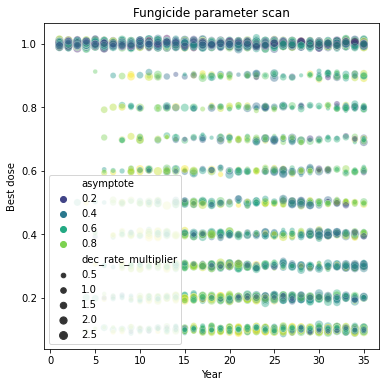

In [6]:
f, ax = plt.subplots(figsize=(6,6))


eps = 0.005
dft = df.head(10000).assign(best_dose_jitter = lambda x: x.best_dose + np.random.normal(0, eps, size=x.shape[0]))

sns.scatterplot(
    x='year',
    y='best_dose_jitter',
    
    # hue='dec_rate_multiplier',
    hue='asymptote',
    
    size='dec_rate_multiplier',
    
    data=dft,
    ax=ax,
    palette='viridis',
    alpha=0.4,
)

ax.set_xlabel('Year')
ax.set_ylabel('Best dose')

ax.set_title('Fungicide parameter scan')

ax.legend(loc='lower left')

# ax.set_xlim([0,50])

## Type 3

In [100]:
barchartdf = (
    df
    # .loc[lambda x: x.run.isin([0,1,2])]
    .loc[lambda x: x.year<=30]
    .loc[:, ['best_dose', 'run', 'year']]
    .assign(
        low = lambda x: x.best_dose<=0.1,
        midlow = lambda x: ((x.best_dose>0.1)
                            & (x.best_dose<=0.5)),
        midhigh = lambda x: ((x.best_dose>0.5)
                            & (x.best_dose<=0.9)),
        high = lambda x: x.best_dose>0.9,
    )
    .drop(['best_dose', 'run'], axis=1)
    .groupby('year')
    .sum()
    # .assign(
    #     low = lambda x: x.low/10000,
    #     midlow = lambda x: x.midlow/10000,
    #     midhigh = lambda x: x.midhigh/10000,
    #     high = lambda x: x.high/10000,
    # )
)

barchartdf.head(5)

,low,midlow,midhigh,high
year,,,,
1,0,0,0,10000
2,0,8,0,9992
3,11,30,11,9948
4,27,112,38,9823
5,53,231,100,9616


<AxesSubplot:xlabel='year'>

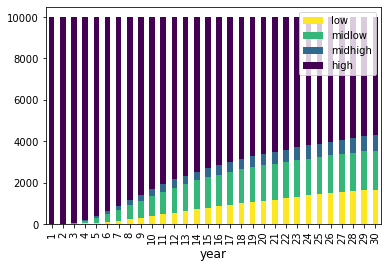

In [101]:
(
    barchartdf
    .plot
    .bar(
        stacked=True,
        colormap='viridis_r',
    )
)

### The plot

In [7]:
df.columns

Index(['run', 'year', 'best_dose', 'n_pos_diff', 'in_0p0_0p1', 'in_0p1_0p2',
       'in_0p2_0p3', 'in_0p3_0p4', 'in_0p4_0p5', 'in_0p5_0p6', 'in_0p6_0p7',
       'in_0p7_0p8', 'in_0p8_0p9', 'in_0p9_1p0', 'mu', 'b', 'asymptote',
       'dec_rate_multiplier', 'm_prop_multiplier', 'm_scale_multiplier',
       'ME_var', 'ME_mean'],
      dtype='object')

Interested in:

- ME_var
- ME_mean
- asympt
- dec_rate_multiplier
- m_prop_multiplier
- m_scale_multiplier

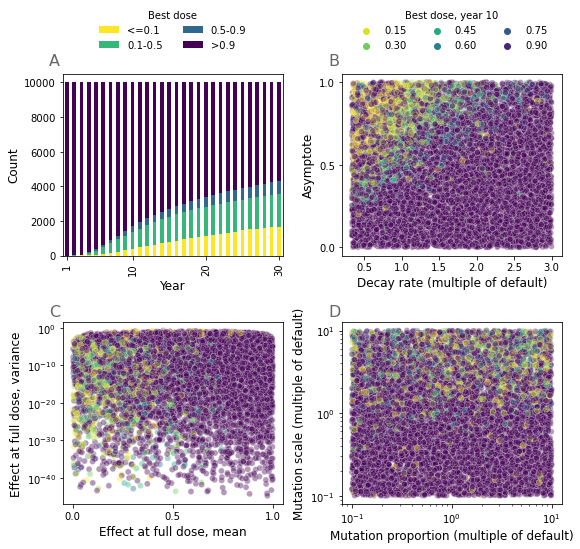

In [143]:
f, ax = plt.subplots(2, 2, figsize=(8, 8))

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title


# eps = 0.005
# dft = (
#     df
#     .loc[lambda x: x.year<=20]
#     # .head(10000)
#     .assign(best_dose_jitter = lambda x: x.best_dose + np.random.normal(0, eps, size=x.shape[0]))
# )

dfu = df.loc[lambda x: x.year.isin([10])]

# sns.scatterplot(
#     x='year',
#     y='best_dose_jitter',
#     hue='ME_mean',
#     # size='ME_mean', # asymptote
#     data=dft,
#     ax=ax[0][0],
#     palette='rocket',
#     alpha=0.4,
# )

(
    barchartdf
    .plot
    .bar(
        stacked=True,
        colormap='viridis_r',
        ax=ax[0][0],
    )
)


# TYPE 2
sns.scatterplot(
    x='dec_rate_multiplier',
    y='asymptote',
    hue='best_dose',
    data=dfu,
    alpha=0.4,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[0][1],
    # legend=False,
)

sns.scatterplot(
    x='ME_mean',
    y='ME_var',
    hue='best_dose',
    data=dfu,
    alpha=0.4,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[1][0],
    legend=False,
)


sns.scatterplot(
    x='m_prop_multiplier',
    y='m_scale_multiplier',
    hue='best_dose',
    data=dfu,
    alpha=0.4,
    palette='viridis_r',
    sizes=(20, 80),
    ax=ax[1][1],
    legend=False,
)



# layout

ax[1][0].set_yscale('log')

ax[1][1].set_xscale('log')
ax[1][1].set_yscale('log')



ax[0][0].set_xlabel('Year')
ax[0][0].set_ylabel('Count')


ax[1][0].set_xlabel('Effect at full dose, mean')
ax[1][0].set_ylabel('Effect at full dose, variance')


ax[0][1].set_xlabel('Decay rate (multiple of default)')
ax[0][1].set_ylabel('Asymptote')

ax[1][1].set_xlabel('Mutation proportion (multiple of default)')
ax[1][1].set_ylabel('Mutation scale (multiple of default)')

ax[0][0].set_xticks([0, 9, 19, 29])

ax[1][0].set_xticks([0, 0.5, 1])
ax[1][0].set_yticks([1e-40, 1e-30, 1e-20, 1e-10, 1])

ax[0][1].set_yticks([0, 0.5, 1])
# ax[0][0].set_xticks([0, 9, 19, 29])
# ax[0][0].set_xticks([0, 9, 19, 29])

plt.tight_layout(rect=[0,0,1,0.85], h_pad=3)

ax[0][0].legend(
    bbox_to_anchor=(0.5, 1.08),
    loc='lower center',
    labels=['<=0.1', '0.1-0.5', '0.5-0.9', '>0.9'],
    title='Best dose',
    ncol=2,
    framealpha=0,
)

ax[0][1].legend(
    # bbox_to_anchor=(0.15, -0.18),
    bbox_to_anchor=(0.5, 1.08),
    loc='lower center', 
    title='Best dose, year 10',
    ncol=3,
    framealpha=0,
    # ncol=6
)


get_corner_annotations(2, 2, 0.085, 0.84, 0.485, 0.435, plt)

In [144]:
f.savefig('../figures/paper/fig3.jpg', dpi=300, bbox_inches="tight")